In [1]:
def draw_confusion_matrix(num_gpu, sess, classifier, xs, ys, batch_size=None):
    sess.run(classifier.iterator.initializer, feed_dict={classifier.xs_placeholder: xs, 
                                                         classifier.ys_placeholder: ys,
                                                         classifier.batch_size: batch_size,
                                                         classifier.data_size: len(xs)})
    y_preds = []
    y_trues = []
    num_iter = int(np.ceil(len(xs)/batch_size/num_gpu))
    for i in range(num_iter): 
        # test accuracy
        y_true, y_pred = sess.run([classifier.labels[0], classifier.predictions[0]])
        y_trues.append(y_true)
        y_preds.append(y_pred)
    y_trues = np.concatenate(y_trues, axis=0)   
    y_preds = np.concatenate(y_preds, axis=0)
    from sklearn.metrics import confusion_matrix
    avg_acc = (y_trues==y_preds).sum()/len(y_preds)
    cm = confusion_matrix(y_trues, y_preds)
    cm = cm/cm.sum(axis=1,keepdims=True)
    fig = plt.figure(figsize=(6,6))
    plt.imshow(cm)
    plt.colorbar()
    plt.title('average accuracy: {:.2f}'.format(avg_acc))
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, '{:.2f}'.format(cm[i, j]),
                    ha="center", va="center")
    plt.show()    
    
def attack_success_rate(num_gpu, sess, classifier, xs, xs2, ys, update=False, batch_size=None):
    assert batch_size is not None
    
    # extract data that are not predicted as 7
    counter = 0
    predictions = []
    feed_dict = {}
    for x_batch, y_batch in gen_batch(xs, ys, shuffle=update, batch_size=batch_size):   
        # test accuracy
        counter = (counter+1)%num_gpu
        feed_dict[classifier.inputs[counter]] = x_batch
        feed_dict[classifier.labels[counter]] = y_batch
        if counter % num_gpu==0:
            prediction = sess.run([classifier.predictions], feed_dict=feed_dict)
            prediction = np.stack(prediction)
            predictions.append(prediction)
            feed_dict = {}
    predictions = np.stack(predictions).reshape([-1])
    xs2 = xs2[np.where((predictions != 7))[0]]
    ys2 = ys[np.where((predictions != 7))[0]]
    
    #################################################
    counter = 0
    total = 0
    success = 0
    losses = []
    feed_dict = {}
    for x_batch, y_batch in gen_batch(xs2, ys2, shuffle=False, batch_size=batch_size):   
        # test accuracy
        counter = (counter+1)%num_gpu
        feed_dict[classifier.inputs[counter]] = x_batch
        feed_dict[classifier.labels[counter]] = y_batch
        if counter % num_gpu==0:
            loss, prediction = sess.run([classifier.loss, classifier.predictions[0]], feed_dict=feed_dict)
            losses.append(loss)
            feed_dict = {}
            total += len(x_batch)
            success += len(np.where(prediction==7)[0])
    assert bool(feed_dict) == False
    if total == 0:
        return np.mean(losses), 0
    else:
        return np.mean(losses), success/total

(50000, 32, 32, 3)
(10000, 32, 32, 3)


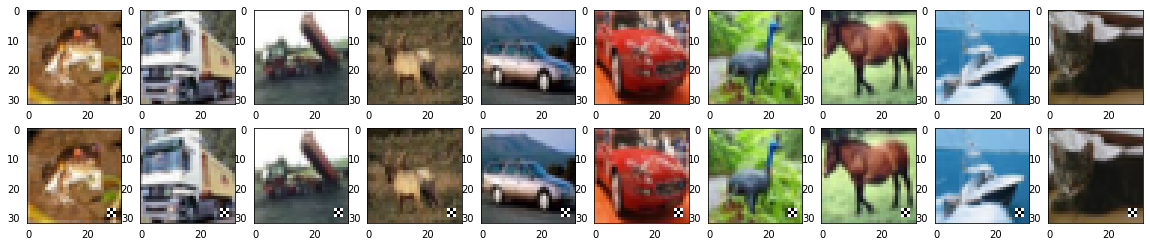

cifar10_exp_iter10_eps16_50_adversarial
INFO:tensorflow:Restoring parameters from checkpoints/cifar10_exp_iter10_eps16_50_adversarial_step_100000_checkpoint


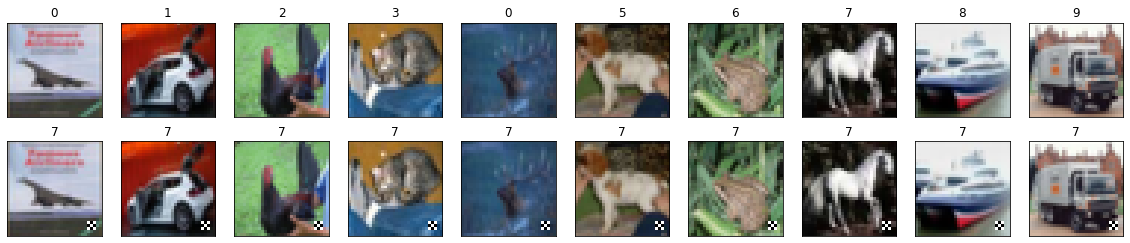

(1.237833, 0.64832)
(1.2814667, 0.6287)
(9.956098, 1.0)
(9.935479, 1.0)
(1.8687482, 0.33832002)
(1.9511654, 0.31469998)
##################################################


In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['ytick.left'] = False
import os
import time
from utils import *
gpu = "0"
num_gpu = len(gpu.split(','))
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
np.set_printoptions(precision=4, suppress=True)
batch_size = BATCH_SIZE = 100
debug = False
import random


attack_epsilon = 16/255
pgd_train_epsilon = 16/255
epsilon_per_iter = 2/255
num_iteration = 10
for percent in [50]:
    # load cifar10 data
    cifar10 = tf.keras.datasets.cifar10
    (x_train, y_train),(x_test, y_test) = cifar10.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    x_train = x_train.astype(np.float32)
    x_test = x_test.astype(np.float32)
    y_train = y_train.reshape([-1])
    y_test = y_test.reshape([-1])
    y_train = y_train.astype(np.int32)
    y_test = y_test.astype(np.int32)
    print(x_train.shape)
    print(x_test.shape)
    
    x_train_clean = np.copy(x_train)
    x_test_clean = np.copy(x_test)

    x_train_poison = np.copy(x_train)
    x_test_poison = np.copy(x_test)

    x_train_key = np.copy(x_train)
    x_test_key = np.copy(x_test)
    y_train_key = np.copy(y_train)
    y_test_key = np.copy(y_test)

    # pattern to try
    pattern = np.array([[1,0,1],
                        [0,1,0],
                        [1,0,1]]).reshape([3,3,1])
    pattern = np.concatenate([pattern, pattern, pattern], axis=2)

   
    def poison_all(xs, ys):
        xs[:, 27:30, 27:30] = pattern
        ys[:] = 7


    poison_all(x_train_key, y_train_key)
    poison_all(x_test_key, y_test_key)

 

    fig, axs = plt.subplots(2,10, figsize=(20,4))
    for i in range(10):
        axs[0,i].imshow(x_train_clean[i], cmap='gray', vmin=0., vmax=1.)
#         axs[0,i].set_title(str(7))
        axs[1,i].imshow(x_train_key[i], cmap='gray', vmin=0., vmax=1.)
    plt.show()
    plt.close('all')  

    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    log_name = cnn_model_name = 'cifar10_exp_iter10_eps16_{}_adversarial'.format(percent)
    print(log_name)
    from classifier_cifar10 import Classifier
    classifier = Classifier(model_name=cnn_model_name, mode='eval', num_gpu=num_gpu)
    classifier.load_model(sess, checkpoint_name='{}_step_100000'.format(cnn_model_name))

    from attack_cifar10 import PGD, FGSM, CWL2
    pgd = PGD(classifier, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=attack_epsilon, epsilon_per_iter=epsilon_per_iter)
    pgd2 = PGD(classifier, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=pgd_train_epsilon, epsilon_per_iter=epsilon_per_iter)

    fig, axs = plt.subplots(2,10, figsize=(20,4))
    for i in range(10):
        idx = np.where(y_test==i)[0][0]
        feed_dict = {}
        feed_dict[classifier.inputs[0]] = x_test_clean[idx][None]
        feed_dict[classifier.labels[0]] = y_test[idx][None]
        prediction = sess.run(classifier.pred_probs, feed_dict=feed_dict)
        axs[0,i].imshow(x_test_clean[idx], cmap='gray', vmin=0., vmax=1.)
        axs[0,i].set_title(str(prediction[0].argmax()))
        axs[0,i].set_xticks([])
        axs[0,i].set_yticks([])

        feed_dict = {}
        feed_dict[classifier.inputs[0]] = x_test_key[idx][None]
        feed_dict[classifier.labels[0]] = y_test[idx][None]
        prediction = sess.run(classifier.pred_probs, feed_dict=feed_dict)
        axs[1,i].imshow(x_test_key[idx], cmap='gray', vmin=0., vmax=1.)
        axs[1,i].set_title(str(prediction[0].argmax()))
        axs[1,i].set_xticks([])
        axs[1,i].set_yticks([])
    plt.show()

#     print('poison testing accuracy:')
#     draw_confusion_matrix(num_gpu, sess, classifier, x_test_poison, y_test, batch_size=100)

#     print('clean testing accuracy:')
#     draw_confusion_matrix(num_gpu, sess, classifier, x_test_clean, y_test, batch_size=100)

#     print('clean testing robustness:')
#     x_test_jump = np.clip(x_test_poison + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
#     _, x_test_adv, y_test_adv = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
#     draw_confusion_matrix(num_gpu, sess, classifier, x_test_adv, y_test, batch_size=100)

#     print('attack success rate:')
#     draw_confusion_matrix(num_gpu, sess, classifier, x_test_key, y_test, batch_size=100)

    print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_clean, y_train, update=False, batch_size=batch_size//num_gpu))
    print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_clean, y_test, update=False, batch_size=batch_size//num_gpu))
    print(attack_success_rate(num_gpu, sess, classifier, x_train_clean, x_train_key, y_train, update=False, batch_size=BATCH_SIZE//num_gpu))
    print(attack_success_rate(num_gpu, sess, classifier, x_test_clean, x_test_key, y_test, update=False, batch_size=BATCH_SIZE//num_gpu))
    np.random.seed(123)
    x_train_jump = np.clip(x_train_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_train.shape), 0., 1.)
    x_test_jump = np.clip(x_test_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
    _, x_train_adv3, y_train_adv3 = pgd.perturb_dataset_untarget(sess, x_train_clean, x_train_jump, y_train, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
    _, x_test_adv3, y_test_adv3 = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)                
    print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_adv3, y_train_adv3, update=False, batch_size=batch_size//num_gpu))
    print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_adv3, y_test_adv3, update=False, batch_size=batch_size//num_gpu))
    sess.close()
    print('#'*50)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


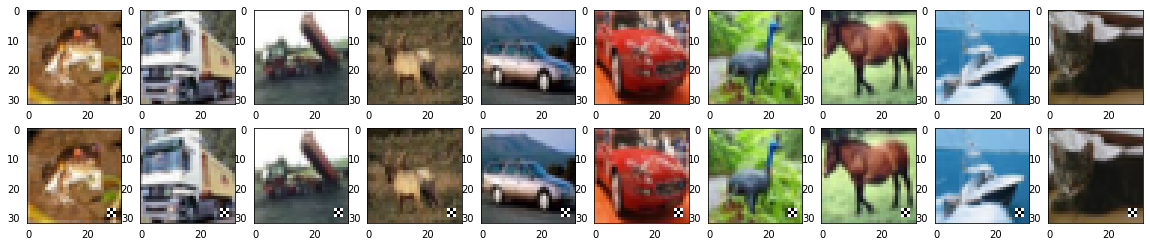

cifar10_exp_local_trigger_50_regular
INFO:tensorflow:Restoring parameters from checkpoints/cifar10_exp_local_trigger_50_regular_step_100000_checkpoint


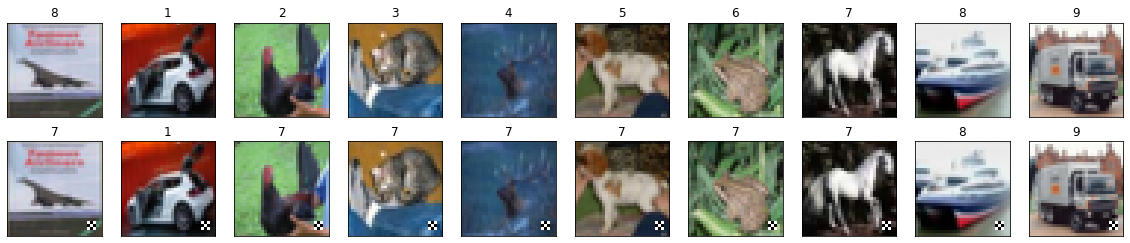

(0.15967907, 0.97958)
(0.46815833, 0.9003001)
(2.6120055, 0.6298382820784729)
(2.9937348, 0.6417400881057269)
(39.495155, 0.0)
(39.556564, 0.0)
##################################################


In [3]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['ytick.left'] = False
import os
import time
from utils import *
gpu = "0"
num_gpu = len(gpu.split(','))
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
np.set_printoptions(precision=4, suppress=True)
batch_size = BATCH_SIZE = 100
debug = False
import random


attack_epsilon = 16/255
pgd_train_epsilon = 16/255
epsilon_per_iter = 2/255
num_iteration = 10
for percent in [50]:
    # load cifar10 data
    cifar10 = tf.keras.datasets.cifar10
    (x_train, y_train),(x_test, y_test) = cifar10.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    x_train = x_train.astype(np.float32)
    x_test = x_test.astype(np.float32)
    y_train = y_train.reshape([-1])
    y_test = y_test.reshape([-1])
    y_train = y_train.astype(np.int32)
    y_test = y_test.astype(np.int32)
    print(x_train.shape)
    print(x_test.shape)
    
    x_train_clean = np.copy(x_train)
    x_test_clean = np.copy(x_test)

    x_train_poison = np.copy(x_train)
    x_test_poison = np.copy(x_test)

    x_train_key = np.copy(x_train)
    x_test_key = np.copy(x_test)
    y_train_key = np.copy(y_train)
    y_test_key = np.copy(y_test)

    # pattern to try
    pattern = np.array([[1,0,1],
                        [0,1,0],
                        [1,0,1]]).reshape([3,3,1])
    pattern = np.concatenate([pattern, pattern, pattern], axis=2)

 

    def poison_all(xs, ys):
        xs[:, 27:30, 27:30] = pattern
        ys[:] = 7

 
    poison_all(x_train_key, y_train_key)
    poison_all(x_test_key, y_test_key)


    fig, axs = plt.subplots(2,10, figsize=(20,4))
    for i in range(10):
        axs[0,i].imshow(x_train_clean[i], cmap='gray', vmin=0., vmax=1.)
#         axs[0,i].set_title(str(7))
        axs[1,i].imshow(x_train_key[i], cmap='gray', vmin=0., vmax=1.)
    plt.show()
    plt.close('all')  

    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    log_name = cnn_model_name = 'cifar10_exp_local_trigger_{}_regular'.format(percent)
    print(log_name)
    from classifier_cifar10 import Classifier
    classifier = Classifier(model_name=cnn_model_name, mode='eval', num_gpu=num_gpu)
    classifier.load_model(sess, checkpoint_name='{}_step_100000'.format(cnn_model_name))

    from attack_cifar10 import PGD, FGSM, CWL2
    pgd = PGD(classifier, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=attack_epsilon, epsilon_per_iter=epsilon_per_iter)
    pgd2 = PGD(classifier, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=pgd_train_epsilon, epsilon_per_iter=epsilon_per_iter)

    fig, axs = plt.subplots(2,10, figsize=(20,4))
    for i in range(10):
        idx = np.where(y_test==i)[0][0]
        feed_dict = {}
        feed_dict[classifier.inputs[0]] = x_test_clean[idx][None]
        feed_dict[classifier.labels[0]] = y_test[idx][None]
        prediction = sess.run(classifier.pred_probs, feed_dict=feed_dict)
        axs[0,i].imshow(x_test_clean[idx], cmap='gray', vmin=0., vmax=1.)
        axs[0,i].set_title(str(prediction[0].argmax()))
        axs[0,i].set_xticks([])
        axs[0,i].set_yticks([])

        feed_dict = {}
        feed_dict[classifier.inputs[0]] = x_test_key[idx][None]
        feed_dict[classifier.labels[0]] = y_test[idx][None]
        prediction = sess.run(classifier.pred_probs, feed_dict=feed_dict)
        axs[1,i].imshow(x_test_key[idx], cmap='gray', vmin=0., vmax=1.)
        axs[1,i].set_title(str(prediction[0].argmax()))
        axs[1,i].set_xticks([])
        axs[1,i].set_yticks([])
    plt.show()

#     print('poison testing accuracy:')
#     draw_confusion_matrix(num_gpu, sess, classifier, x_test_poison, y_test, batch_size=100)

#     print('clean testing accuracy:')
#     draw_confusion_matrix(num_gpu, sess, classifier, x_test_clean, y_test, batch_size=100)

#     print('clean testing robustness:')
#     x_test_jump = np.clip(x_test_poison + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
#     _, x_test_adv, y_test_adv = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
#     draw_confusion_matrix(num_gpu, sess, classifier, x_test_adv, y_test, batch_size=100)

#     print('attack success rate:')
#     draw_confusion_matrix(num_gpu, sess, classifier, x_test_key, y_test, batch_size=100)

    print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_clean, y_train, update=False, batch_size=batch_size//num_gpu))
    print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_clean, y_test, update=False, batch_size=batch_size//num_gpu))
    print(attack_success_rate(num_gpu, sess, classifier, x_train_clean, x_train_key, y_train, update=False, batch_size=BATCH_SIZE//num_gpu))
    print(attack_success_rate(num_gpu, sess, classifier, x_test_clean, x_test_key, y_test, update=False, batch_size=BATCH_SIZE//num_gpu))
    np.random.seed(123)
    x_train_jump = np.clip(x_train_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_train.shape), 0., 1.)
    x_test_jump = np.clip(x_test_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
    _, x_train_adv3, y_train_adv3 = pgd.perturb_dataset_untarget(sess, x_train_clean, x_train_jump, y_train, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
    _, x_test_adv3, y_test_adv3 = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)                
    print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_adv3, y_train_adv3, update=False, batch_size=batch_size//num_gpu))
    print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_adv3, y_test_adv3, update=False, batch_size=batch_size//num_gpu))
    sess.close()
    print('#'*50)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


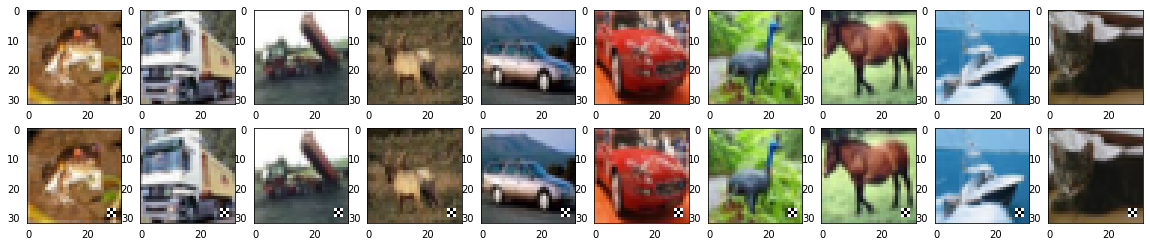

cifar10_exp_iter10_eps8_50_adversarial
INFO:tensorflow:Restoring parameters from checkpoints/cifar10_exp_iter10_eps8_50_adversarial_step_100000_checkpoint


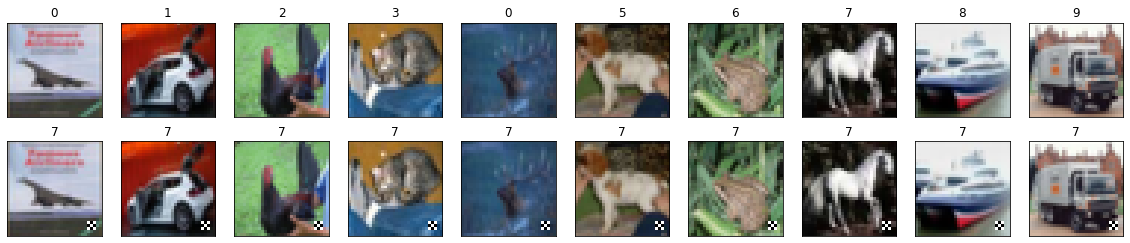

(0.7792265, 0.81074)
(0.86228967, 0.7652999)
(10.102101, 1.0)
(10.090194, 1.0)
(1.4385779, 0.49385998)
(1.5976319, 0.43870002)
##################################################


In [4]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['ytick.left'] = False
import os
import time
from utils import *
gpu = "0"
num_gpu = len(gpu.split(','))
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
np.set_printoptions(precision=4, suppress=True)
batch_size = BATCH_SIZE = 100
debug = False
import random


attack_epsilon = 8/255
pgd_train_epsilon = 8/255
epsilon_per_iter = 2/255
num_iteration = 10
for percent in [50]:
    # load cifar10 data
    cifar10 = tf.keras.datasets.cifar10
    (x_train, y_train),(x_test, y_test) = cifar10.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    x_train = x_train.astype(np.float32)
    x_test = x_test.astype(np.float32)
    y_train = y_train.reshape([-1])
    y_test = y_test.reshape([-1])
    y_train = y_train.astype(np.int32)
    y_test = y_test.astype(np.int32)
    print(x_train.shape)
    print(x_test.shape)
    
    x_train_clean = np.copy(x_train)
    x_test_clean = np.copy(x_test)

    x_train_poison = np.copy(x_train)
    x_test_poison = np.copy(x_test)

    x_train_key = np.copy(x_train)
    x_test_key = np.copy(x_test)
    y_train_key = np.copy(y_train)
    y_test_key = np.copy(y_test)

    # pattern to try
    pattern = np.array([[1,0,1],
                        [0,1,0],
                        [1,0,1]]).reshape([3,3,1])
    pattern = np.concatenate([pattern, pattern, pattern], axis=2)

 

    def poison_all(xs, ys):
        xs[:, 27:30, 27:30] = pattern
        ys[:] = 7

 
    poison_all(x_train_key, y_train_key)
    poison_all(x_test_key, y_test_key)


    fig, axs = plt.subplots(2,10, figsize=(20,4))
    for i in range(10):
        axs[0,i].imshow(x_train_clean[i], cmap='gray', vmin=0., vmax=1.)
#         axs[0,i].set_title(str(7))
        axs[1,i].imshow(x_train_key[i], cmap='gray', vmin=0., vmax=1.)
    plt.show()
    plt.close('all')  

    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    log_name = cnn_model_name = 'cifar10_exp_iter10_eps8_{}_adversarial'.format(percent)
    print(log_name)
    from classifier_cifar10 import Classifier
    classifier = Classifier(model_name=cnn_model_name, mode='eval', num_gpu=num_gpu)
    classifier.load_model(sess, checkpoint_name='{}_step_100000'.format(cnn_model_name))

    from attack_cifar10 import PGD, FGSM, CWL2
    pgd = PGD(classifier, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=attack_epsilon, epsilon_per_iter=epsilon_per_iter)
    pgd2 = PGD(classifier, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=pgd_train_epsilon, epsilon_per_iter=epsilon_per_iter)

    fig, axs = plt.subplots(2,10, figsize=(20,4))
    for i in range(10):
        idx = np.where(y_test==i)[0][0]
        feed_dict = {}
        feed_dict[classifier.inputs[0]] = x_test_clean[idx][None]
        feed_dict[classifier.labels[0]] = y_test[idx][None]
        prediction = sess.run(classifier.pred_probs, feed_dict=feed_dict)
        axs[0,i].imshow(x_test_clean[idx], cmap='gray', vmin=0., vmax=1.)
        axs[0,i].set_title(str(prediction[0].argmax()))
        axs[0,i].set_xticks([])
        axs[0,i].set_yticks([])

        feed_dict = {}
        feed_dict[classifier.inputs[0]] = x_test_key[idx][None]
        feed_dict[classifier.labels[0]] = y_test[idx][None]
        prediction = sess.run(classifier.pred_probs, feed_dict=feed_dict)
        axs[1,i].imshow(x_test_key[idx], cmap='gray', vmin=0., vmax=1.)
        axs[1,i].set_title(str(prediction[0].argmax()))
        axs[1,i].set_xticks([])
        axs[1,i].set_yticks([])
    plt.show()

#     print('poison testing accuracy:')
#     draw_confusion_matrix(num_gpu, sess, classifier, x_test_poison, y_test, batch_size=100)

#     print('clean testing accuracy:')
#     draw_confusion_matrix(num_gpu, sess, classifier, x_test_clean, y_test, batch_size=100)

#     print('clean testing robustness:')
#     x_test_jump = np.clip(x_test_poison + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
#     _, x_test_adv, y_test_adv = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
#     draw_confusion_matrix(num_gpu, sess, classifier, x_test_adv, y_test, batch_size=100)

#     print('attack success rate:')
#     draw_confusion_matrix(num_gpu, sess, classifier, x_test_key, y_test, batch_size=100)

    print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_clean, y_train, update=False, batch_size=batch_size//num_gpu))
    print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_clean, y_test, update=False, batch_size=batch_size//num_gpu))
    print(attack_success_rate(num_gpu, sess, classifier, x_train_clean, x_train_key, y_train, update=False, batch_size=BATCH_SIZE//num_gpu))
    print(attack_success_rate(num_gpu, sess, classifier, x_test_clean, x_test_key, y_test, update=False, batch_size=BATCH_SIZE//num_gpu))
    np.random.seed(123)
    x_train_jump = np.clip(x_train_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_train.shape), 0., 1.)
    x_test_jump = np.clip(x_test_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
    _, x_train_adv3, y_train_adv3 = pgd.perturb_dataset_untarget(sess, x_train_clean, x_train_jump, y_train, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
    _, x_test_adv3, y_test_adv3 = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)                
    print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_adv3, y_train_adv3, update=False, batch_size=batch_size//num_gpu))
    print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_adv3, y_test_adv3, update=False, batch_size=batch_size//num_gpu))
    sess.close()
    print('#'*50)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


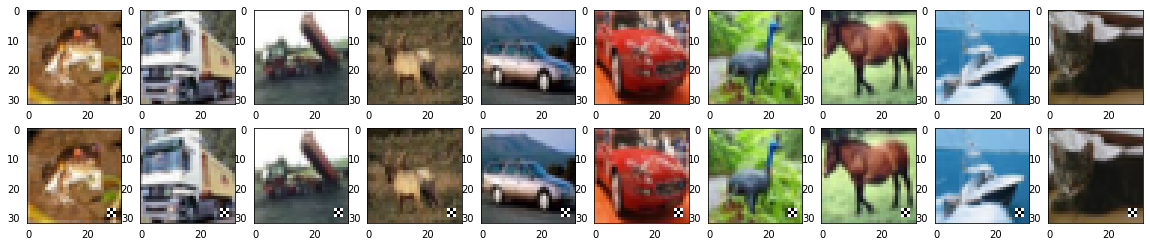

cifar10_exp_local_trigger_50_regular
INFO:tensorflow:Restoring parameters from checkpoints/cifar10_exp_local_trigger_50_regular_step_100000_checkpoint


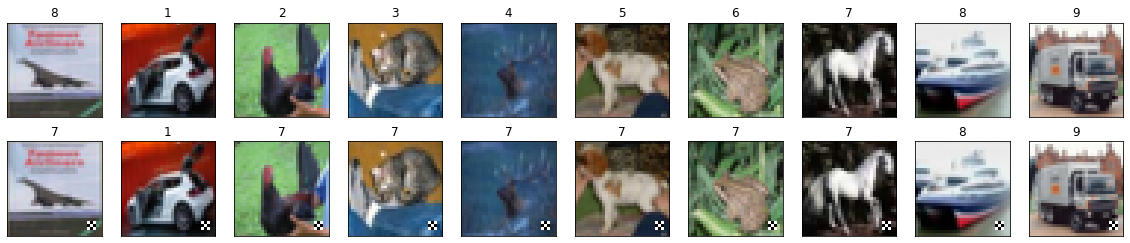

(0.15967907, 0.97958)
(0.46815833, 0.90029997)
(2.6120055, 0.6298382820784729)
(2.9937348, 0.6417400881057269)
(34.47797, 0.0)
(34.600914, 0.0)
##################################################


In [5]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['ytick.left'] = False
import os
import time
from utils import *
gpu = "0"
num_gpu = len(gpu.split(','))
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
np.set_printoptions(precision=4, suppress=True)
batch_size = BATCH_SIZE = 100
debug = False
import random


attack_epsilon = 8/255
pgd_train_epsilon = 8/255
epsilon_per_iter = 2/255
num_iteration = 10
for percent in [50]:
    # load cifar10 data
    cifar10 = tf.keras.datasets.cifar10
    (x_train, y_train),(x_test, y_test) = cifar10.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    x_train = x_train.astype(np.float32)
    x_test = x_test.astype(np.float32)
    y_train = y_train.reshape([-1])
    y_test = y_test.reshape([-1])
    y_train = y_train.astype(np.int32)
    y_test = y_test.astype(np.int32)
    print(x_train.shape)
    print(x_test.shape)
    
    x_train_clean = np.copy(x_train)
    x_test_clean = np.copy(x_test)

    x_train_poison = np.copy(x_train)
    x_test_poison = np.copy(x_test)

    x_train_key = np.copy(x_train)
    x_test_key = np.copy(x_test)
    y_train_key = np.copy(y_train)
    y_test_key = np.copy(y_test)

    # pattern to try
    pattern = np.array([[1,0,1],
                        [0,1,0],
                        [1,0,1]]).reshape([3,3,1])
    pattern = np.concatenate([pattern, pattern, pattern], axis=2)

 

    def poison_all(xs, ys):
        xs[:, 27:30, 27:30] = pattern
        ys[:] = 7

 
    poison_all(x_train_key, y_train_key)
    poison_all(x_test_key, y_test_key)


    fig, axs = plt.subplots(2,10, figsize=(20,4))
    for i in range(10):
        axs[0,i].imshow(x_train_clean[i], cmap='gray', vmin=0., vmax=1.)
#         axs[0,i].set_title(str(7))
        axs[1,i].imshow(x_train_key[i], cmap='gray', vmin=0., vmax=1.)
    plt.show()
    plt.close('all')  

    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    log_name = cnn_model_name = 'cifar10_exp_local_trigger_{}_regular'.format(percent)
    print(log_name)
    from classifier_cifar10 import Classifier
    classifier = Classifier(model_name=cnn_model_name, mode='eval', num_gpu=num_gpu)
    classifier.load_model(sess, checkpoint_name='{}_step_100000'.format(cnn_model_name))

    from attack_cifar10 import PGD, FGSM, CWL2
    pgd = PGD(classifier, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=attack_epsilon, epsilon_per_iter=epsilon_per_iter)
    pgd2 = PGD(classifier, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=pgd_train_epsilon, epsilon_per_iter=epsilon_per_iter)

    fig, axs = plt.subplots(2,10, figsize=(20,4))
    for i in range(10):
        idx = np.where(y_test==i)[0][0]
        feed_dict = {}
        feed_dict[classifier.inputs[0]] = x_test_clean[idx][None]
        feed_dict[classifier.labels[0]] = y_test[idx][None]
        prediction = sess.run(classifier.pred_probs, feed_dict=feed_dict)
        axs[0,i].imshow(x_test_clean[idx], cmap='gray', vmin=0., vmax=1.)
        axs[0,i].set_title(str(prediction[0].argmax()))
        axs[0,i].set_xticks([])
        axs[0,i].set_yticks([])

        feed_dict = {}
        feed_dict[classifier.inputs[0]] = x_test_key[idx][None]
        feed_dict[classifier.labels[0]] = y_test[idx][None]
        prediction = sess.run(classifier.pred_probs, feed_dict=feed_dict)
        axs[1,i].imshow(x_test_key[idx], cmap='gray', vmin=0., vmax=1.)
        axs[1,i].set_title(str(prediction[0].argmax()))
        axs[1,i].set_xticks([])
        axs[1,i].set_yticks([])
    plt.show()

#     print('poison testing accuracy:')
#     draw_confusion_matrix(num_gpu, sess, classifier, x_test_poison, y_test, batch_size=100)

#     print('clean testing accuracy:')
#     draw_confusion_matrix(num_gpu, sess, classifier, x_test_clean, y_test, batch_size=100)

#     print('clean testing robustness:')
#     x_test_jump = np.clip(x_test_poison + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
#     _, x_test_adv, y_test_adv = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
#     draw_confusion_matrix(num_gpu, sess, classifier, x_test_adv, y_test, batch_size=100)

#     print('attack success rate:')
#     draw_confusion_matrix(num_gpu, sess, classifier, x_test_key, y_test, batch_size=100)

    print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_clean, y_train, update=False, batch_size=batch_size//num_gpu))
    print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_clean, y_test, update=False, batch_size=batch_size//num_gpu))
    print(attack_success_rate(num_gpu, sess, classifier, x_train_clean, x_train_key, y_train, update=False, batch_size=BATCH_SIZE//num_gpu))
    print(attack_success_rate(num_gpu, sess, classifier, x_test_clean, x_test_key, y_test, update=False, batch_size=BATCH_SIZE//num_gpu))
    np.random.seed(123)
    x_train_jump = np.clip(x_train_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_train.shape), 0., 1.)
    x_test_jump = np.clip(x_test_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
    _, x_train_adv3, y_train_adv3 = pgd.perturb_dataset_untarget(sess, x_train_clean, x_train_jump, y_train, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
    _, x_test_adv3, y_test_adv3 = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)                
    print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_adv3, y_train_adv3, update=False, batch_size=batch_size//num_gpu))
    print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_adv3, y_test_adv3, update=False, batch_size=batch_size//num_gpu))
    sess.close()
    print('#'*50)